# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from scipy import signal
from lhcsmapi.Time import Time
from lhcsmapi.metadata import signal_metadata
from lhcsmapi.pyedsl.dbsignal.post_mortem.PmDbRequest import PmDbRequest
from lhcsmapi.analysis.RbCircuitQuery import RbCircuitQuery

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex, load_u_diode_nxcals
from src.modeling.sec_quench import *

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

# Read the (clean) MP3 file

In [3]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2021_11_22_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])

# Time.to_string(1514761200000000000), Time.to_unix_timestamp('2018-01-01 00:00:00+01:00')
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

# Plot Udiode

In [4]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')

data_path = file_path / 'data'
simulation_path = file_path / 'PSPICE'
plots_path = file_path / 'plots_u_diode'

In [7]:
mp3_fpa_df[mp3_fpa_df.timestamp_fgc==1465578785320000000]

,Unnamed: 0,Unnamed: 0.1,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),...,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47,timestamp_fgc
60,60,62,RB.A12,RB,Operation 2016,2016-06-10 00:00:00,19:13:05,Unknown,NaN,NaN,...,12360,-,NaN,https://issues.cern.ch/browse/TEMPECOMS-592,NaN,NaN,NaN,NaN,NaN,1.465579e+18


In [10]:
mp3_fpa_df_period[mp3_fpa_df_period["Date (FGC)"]=="2016-03-25 00:00:00"]

,Unnamed: 0,Unnamed: 0.1,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),...,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47,timestamp_fgc


Text(0, 0.5, 'Voltage \\ V')

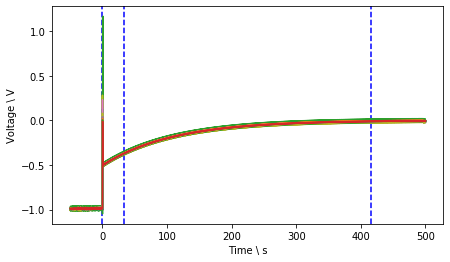

In [8]:
fpa_identifier = f"RB_RB.A12_{1465578785320000000}"

fig_dir = str(plots_path / (fpa_identifier+".png"))
data_dir = data_path / (fpa_identifier + ".hdf5")

df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == int(row['timestamp_fgc'])) & (mp3_fpa_df["Circuit Name"] == row['Circuit Name'])]

df_data_nxcals = load_u_diode_nxcals(data_dir)
fig, ax = plt.subplots(figsize=(7,4))
quenc_times = df_subset['Delta_t(iQPS-PIC)'].values
for quenc_time in quenc_times:
    ax.axvline(quenc_time/1e3, color='b', linestyle='--', label="time of next quench")
df_data_nxcals.plot(legend=False, ax = ax)

ax.set_xlabel("Time \ s")
ax.set_ylabel("Voltage \ V")

In [6]:
i = 1
for index, row in mp3_fpa_df_period.iterrows():
    fpa_identifier = f"{row['Circuit Family']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}"
    fig_dir = str(plots_path / (fpa_identifier+".png"))
    data_dir = data_path / (fpa_identifier + ".hdf5")
    if not os.path.isfile(fig_dir):
        df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == int(row['timestamp_fgc'])) & (mp3_fpa_df["Circuit Name"] == row['Circuit Name'])]

        df_data_nxcals = load_u_diode_nxcals(data_dir)
        fig, ax = plt.subplots(figsize=(7,4))
        quenc_times = df_subset['Delta_t(iQPS-PIC)'].values
        for quenc_time in quenc_times:
            ax.axvline(quenc_time/1e3, color='b', linestyle='--', label="time of next quench")
        df_data_nxcals.plot(legend=False, ax = ax)

        ax.set_xlabel("Time \ s")
        ax.set_ylabel("Voltage \ V")

        plt.savefig(fig_dir)
        fig.clf()
    print(f"{i}/{len(mp3_fpa_df_period)} plotted" )
    i +=1
    

1/828 plotted
2/828 plotted
3/828 plotted
4/828 plotted
5/828 plotted
6/828 plotted
7/828 plotted
8/828 plotted
9/828 plotted
10/828 plotted
11/828 plotted
12/828 plotted
13/828 plotted
14/828 plotted
15/828 plotted
16/828 plotted
17/828 plotted
18/828 plotted
19/828 plotted
20/828 plotted
21/828 plotted
22/828 plotted
23/828 plotted
24/828 plotted
25/828 plotted
26/828 plotted
27/828 plotted
28/828 plotted
29/828 plotted
30/828 plotted
31/828 plotted
32/828 plotted
33/828 plotted
34/828 plotted
35/828 plotted
36/828 plotted
37/828 plotted
38/828 plotted
39/828 plotted
40/828 plotted
41/828 plotted
42/828 plotted
43/828 plotted
44/828 plotted
45/828 plotted
46/828 plotted
47/828 plotted
48/828 plotted
49/828 plotted
50/828 plotted
51/828 plotted
52/828 plotted
53/828 plotted
54/828 plotted
55/828 plotted
56/828 plotted
57/828 plotted
58/828 plotted
59/828 plotted
60/828 plotted
61/828 plotted
62/828 plotted
63/828 plotted
64/828 plotted
65/828 plotted
66/828 plotted
67/828 plotted
68/8

520/828 plotted
521/828 plotted
522/828 plotted
523/828 plotted
524/828 plotted
525/828 plotted
526/828 plotted
527/828 plotted
528/828 plotted
529/828 plotted
530/828 plotted
531/828 plotted
532/828 plotted
533/828 plotted
534/828 plotted
535/828 plotted
536/828 plotted
537/828 plotted
538/828 plotted
539/828 plotted
540/828 plotted
541/828 plotted
542/828 plotted
543/828 plotted
544/828 plotted
545/828 plotted
546/828 plotted
547/828 plotted
548/828 plotted
549/828 plotted
550/828 plotted
551/828 plotted
552/828 plotted
553/828 plotted
554/828 plotted
555/828 plotted
556/828 plotted
557/828 plotted
558/828 plotted
559/828 plotted
560/828 plotted
561/828 plotted
562/828 plotted
563/828 plotted
564/828 plotted
565/828 plotted
566/828 plotted
567/828 plotted
568/828 plotted
569/828 plotted
570/828 plotted
571/828 plotted
572/828 plotted
573/828 plotted
574/828 plotted
575/828 plotted
576/828 plotted
577/828 plotted
578/828 plotted
579/828 plotted
580/828 plotted
581/828 plotted
582/828 

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

In [ ]:
df_data_nxcals